In [ ]:
#!jupyter nbconvert --to=python Chlsurf_OCCCI_Comparison_python3.ipynb

In [119]:
class Chlsurf_OCCCI_comp:
    '''
    class Chlsurf_OCCCI_comp(runname,resultpath,savepath,meshpath,matfileChlsurf,first_year,last_year,
                 mapproj='pc',savefig=False,layerwise=False,n_levels = 1)
                 
    n_levels = 1: number of mesh levels used for FESOM surface mean
    '''
    
    def __init__(self,runname,resultpath,savepath,meshpath,matfileChlsurf,first_year,last_year,
                 mapproj='pc',
                 savefig=False,
                 layerwise=False,depth_array=[],
                 n_levels = 1):

        self.runname = runname
        self.resultpath = resultpath
        self.savepath = savepath
        self.meshpath = meshpath
        self.fyear = first_year
        self.lyear = last_year
        self.mapproj = mapproj
        self.savefig = savefig
        self.layerwise = layerwise
        self.depth_array = depth_array
        self.n_levels = n_levels
        self.matfileChlsurf=matfileChlsurf
        

        import matplotlib.pyplot as plt
        import matplotlib.colors as colors
        import numpy as np
        #from netCDF4 import Dataset
        from scipy.interpolate import griddata
        import skill_metrics as sm
        import cartopy.crs as ccrs
        #import pickle
        import scipy.io as spio


        import pyfesom2 as pf
        
        from plot_Taylor_normalized import plt_Taylor_norm
        
        if(self.mapproj == 'rob'): self.mapproj = ccrs.Robinson()
        elif(self.mapproj == 'pc'): self.mapproj = ccrs.PlateCarree()
        else: raise ValueError('Map projection not supported!')
        
        if(self.layerwise != False): raise ValueError('Layerwise processing not suported.')
        
        # load OCCCI CHl.a data -------------------------------------------------------------------------------------
        matChl = spio.loadmat(self.matfileChlsurf, squeeze_me=True)
        
        lat         = np.arange(-89.5,90.,1.)
        lon         = np.arange(-179.5,180.,1.)
        latdic, londic = np.meshgrid(lat, lon)
        
        #annualchl   = np.log10(matChl['x'])
        OCCCIchla = matChl['x']
        OCCCIchla_log10 = np.log10(OCCCIchla)
        
        OCCCIlabel = 'OCCCI: Surface Chl concentration'
        OCCCIunit = 'Surface Chl.a [mg Chl m$^{-3}$]'
                
        
        # load FESOM mesh -------------------------------------------------------------------------------------
        mesh       = pf.load_mesh(self.meshpath)
        years = [self.fyear, self.lyear]
        
        lon_fesom = mesh.x2
        lat_fesom = mesh.y2        
        
        # surface: mean over n mesh levels
        #self.n_levels
        f_depth = mesh.zlev[self.n_levels]
        print('***\nUsing upper {0} layers to depth {1} m for surface FESOM data!\n***'.format(
            n_levels,f_depth))
        
        # load FESOM Nanophyto Chl.a data -------------------------------------------------------------------------------------        
        ncFESOMChl = self.resultpath + '/ChlA.fesom.1948.nc'
        !ncdump -h $ncFESOMChl
        
        ChlAfesom = pf.get_data(self.resultpath, "ChlA", years, mesh, 
                               how="mean", compute=True, runid=self.runname, silent=True)
        
        
        ChlAfesom_surf = np.nanmean(ChlAfesom[:,:n_levels],axis=1)
        
        # mean over whole water column
        #ChlAfesom_mean = np.nanmean(ChlAfesom, axis=1)
        
        labelfesomNano = 'FESOM Nanophyto Chl.a {0}-{1}'.format(self.fyear,self.lyear)        
        #unitfesomNano = 'Chl.a [mmol m$^{-3}$]' 

        # load FESOM Diatom Chl.a data -------------------------------------------------------------------------------------
        
        ncFESOMDiaChl = self.resultpath + '/DiaChl.fesom.1948.nc'
        !ncdump -h $ncFESOMDiaChl
        
        DiaChlfesom = pf.get_data(self.resultpath, "DiaChl", years, mesh, 
                               how="mean", compute=True, runid=self.runname, silent=True)
        
        labelfesomDia = 'FESOM Diatom Chl.a {0}-{1}'.format(self.fyear,self.lyear)
        
        # surface: mean over n mesh levels
        DiaChlfesom_surf = np.nanmean(DiaChlfesom[:,:n_levels],axis=1)
        
        # convert FESOM CHl.a data -------------------------------------------------------------------------------------
        # #########################
        # FESOM outputs the data in mg/m3 already, wrong units set in netcdf !?!?!
        # #########################
        if False:
            #Chl.a : 893.509 g/mol
            conv = 893.509
            ChlAfesom_surf = ChlAfesom_surf * conv # mmol/m3 to mg/m3
        else: print('***\nFESOM data in not converted...\n***')
    
        unitfesom = 'FESOM Chl.a [mg m$^{-3}$]'
        labelfesom = 'FESOM SUM Chl.a {0}-{1}'.format(self.fyear,self.lyear)

        
        # interpolate FESOM CHl.a to regular -------------------------------------------------------------------------------------
        ChlAfesom_surf_interp = pf.fesom2regular(
                data = ChlAfesom_surf,
                mesh = mesh,
                lons = londic, 
                lats = latdic)
        
        DiaChlfesom_surf_interp = pf.fesom2regular(
                data = DiaChlfesom_surf,
                mesh = mesh,
                lons = londic, 
                lats = latdic)
        
        # Nanophyto + Diatoms: TOTAL CHLOROPHYLL -------------------------------------------------------------------------------------
        ChlAfesom_surf_interp_log10 = np.log10(ChlAfesom_surf_interp)
        DiaChlfesom_surf_interp_log10 = np.log10(DiaChlfesom_surf_interp)
        
        Chl_total = ChlAfesom_surf_interp + DiaChlfesom_surf_interp
        Chl_total_log10 = np.log10(Chl_total)
        
        if False: # interpolation check
            Chl_total_preinterp = ChlAfesom_surf + DiaChlfesom_surf
            
            print('\nFESOM interpolation check:\noriginal min {0:5.4f} max {1:5.4f} mean {2:5.4f} \ninterpol min {3:5.4f} max {4:5.4f} mean {5:5.4f}'.format(
                np.nanmin(Chl_total_preinterp),np.nanmax(Chl_total_preinterp),np.nanmean(Chl_total_preinterp),
                np.nanmin(Chl_total),np.nanmax(Chl_total),np.nanmean(Chl_total)))
        
            fig = plt.figure(figsize=(10,10))
            ax1 = plt.subplot(projection = ccrs.Robinson())

            m1 = plt.pcolormesh(londic, latdic, Chl_total, 
                transform = ccrs.PlateCarree(),
                norm=colors.LogNorm(vmin=np.nanmin(Chl_total), 
                                    vmax=np.nanmax(Chl_total)),
                cmap='viridis')

            ax1.coastlines(resolution='110m', color='black', linewidth=1)

            cbar = fig.colorbar(m1,orientation = 'horizontal',fraction=0.1, pad=0.1) 
            cbar.set_label('Interpolated '+unitfesom, fontsize=20)
        
            
        # interpolate OCCCI CHl.a data -------------------------------------------------------------------------------------
        #OCCCIchla = griddata((londic.ravel(), latdic.ravel()), annualchl.ravel(), (lon_fesom, lat_fesom), method='nearest')
        #OCCCIchla = np.ma.filled(OCCCIchla, np.nan)

        # apply sea mask to OCCCI as in FESOM ----------------------------------------------------------------------------------
        # assumption: there is no ocean where value in FESOM == 0
        OCCCIchla_ma = np.copy(OCCCIchla)
        OCCCIchla_ma[~np.isfinite(ChlAfesom_surf_interp)] = np.nan
        
        OCCCIchla_ma_log10 = np.log10(OCCCIchla_ma)
        
        # plot both CHl.a data -------------------------------------------------------------------------------------
        print('\nChl.a\nOCCCI min = {2:5.4f}, max = {3:5.4f}\nFESOM min = {0:5.4f}, max = {1:5.4f} (Mean over 0 to {4} m)'.format(
                np.nanmin(Chl_total),np.nanmax(Chl_total),
                np.nanmin(OCCCIchla_ma),np.nanmax(OCCCIchla_ma),
                f_depth))
        
        print('\nlog10(Chl.a)\nOCCCI min = {2:5.4f}, max = {3:5.4f}\nFESOM min = {0:5.4f}, max = {1:5.4f} (Mean over 0 to {4} m)'.format(
                np.nanmin(Chl_total_log10),np.nanmax(Chl_total_log10),
                np.nanmin(OCCCIchla_ma_log10),np.nanmax(OCCCIchla_ma_log10),
                f_depth))
        
        levels = np.array([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
                           0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
                           1,2,3,4,5,7])
        ticks = [0,0.01,0.03,0.05,0.07,0.1,0.3,0.5,0.7,1,3,5,7]
        ticks_label = ['0','0.01','0.03','0.05','0.07','0.1','0.3','0.5','0.7','1','3','5','7']
        
        def mygrid(m):
            m.coastlines(resolution='110m', color='black', linewidth=1)
            
        fig, axes = plt.subplots(1,3, 
                                 subplot_kw=dict(projection=self.mapproj),
                                 gridspec_kw={'hspace': 0.01, 'wspace': 0.1},
                                 figsize=(20,7))
        # OC-CCI
        m1 = axes[0]
        f1 = m1.pcolormesh(londic, latdic, OCCCIchla_ma, 
                           transform = ccrs.PlateCarree(),
                           norm=colors.BoundaryNorm(boundaries=levels, ncolors=256))
                           #vmin=1e-3,vmax=5e3)
        mygrid(m1)
        m1.set_title('OCCCI', fontsize=16)


        # FESOM
        m2 = axes[1]
        f2 = m2.pcolormesh(londic, latdic, Chl_total, 
                           transform = ccrs.PlateCarree(),
                           norm=colors.BoundaryNorm(boundaries=levels, ncolors=256))
        mygrid(m2)
        m2.set_title('{0}\n(0 to {1} m)'.format(labelfesom,f_depth), fontsize=16)

        # add one colorbar for first row plots below figure
        cbar = fig.colorbar(f1,
                            ax = axes[:2], 
                            location ='bottom',
                            ticks = ticks,
                            fraction=0.1, pad=0.1) 
        #cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(ticks_label, fontsize=16) 
        cbar.set_label('Chl.a [mg m$^{-3}$]', fontsize=16)
        
        # OC-CCI - FESOM
        levels_diff = np.arange(-2,2,0.125)
        m3 = axes[2]
        f3 = m3.pcolormesh(londic, latdic, Chl_total - OCCCIchla_ma, 
                           transform = ccrs.PlateCarree(),
                           cmap = 'RdBu',
                           norm=colors.BoundaryNorm(boundaries=levels_diff, ncolors=256)
                           )
        mygrid(m3)
        m3.set_title('FESOM - OCCCI', fontsize=16)

        # add one colorbar for difference plot below figure
        cbar = fig.colorbar(f3,
                        ax = axes[2], 
                        orientation = 'horizontal',
                        #location ='bottom',
                        ticks = [-2,-1,0,1,2],
                        fraction=0.1, pad=0.1) 
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label('Chl.a [mg m$^{-3}$]', fontsize=16)

        # fig export  -------------------------------------------------------------------------------------
        if(self.savefig==True):
            plt.savefig(self.savepath+self.runname+'_'+'Chla_OCCCI'+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                    dpi = 300, bbox_inches='tight')
        plt.show(block=False)  

        
        # statistics  -------------------------------------------------------------------------------------            
        # preparation of datasets
        if np.isnan(np.min(OCCCIchla_ma_log10)): print('WARNING: OCCCI field contains NaNs')
        if np.isnan(np.min(Chl_total_log10)): print('WARNING: FESOM field contains NaNs')

        # get statistics only from valid OCCCI gridpoints 
        ind_stat = np.where(np.isfinite(OCCCIchla_ma_log10))
        
        title = 'log10 surface Chlorophyll'
        print('\nStatistics for '+title)
        plt_Taylor_norm(OCCCIchla_ma_log10[ind_stat],Chl_total_log10[ind_stat],
                                mask=True,title=title)


        # fig export  -------------------------------------------------------------------------------------
        if(self.savefig==True):                
            plt.savefig(self.savepath+self.runname+'_'+'Chla_OCCCI_Taylor'+'_'+str(years[0])+'to'+str(years[1])+'.png', 
                    dpi = 300, bbox_inches='tight')
        plt.show(block=False) 
        

***
Using upper 1 layers to depth -5.0 m for surface FESOM data!
***
netcdf ChlA.fesom.1948 {
dimensions:
	nz1 = 47 ;
	nod2 = 126858 ;
	time = UNLIMITED ; // (12 currently)
variables:
	double time(time) ;
		time:long_name = "time" ;
		time:units = "seconds since 1948-01-01 0:0:0" ;
	float ChlA(time, nod2, nz1) ;
		ChlA:description = "Current intracellular ChlA conc." ;
		ChlA:units = "[mmol/m3]" ;
}
netcdf DiaChl.fesom.1948 {
dimensions:
	nz1 = 47 ;
	nod2 = 126858 ;
	time = UNLIMITED ; // (12 currently)
variables:
	double time(time) ;
		time:long_name = "time" ;
		time:units = "seconds since 1948-01-01 0:0:0" ;
	float DiaChl(time, nod2, nz1) ;
		DiaChl:description = "DiaChl" ;
		DiaChl:units = "[mmol/m3]" ;
}
***
FESOM data in not converted...
***

Chl.a
OCCCI min = 0.0082, max = 53.4243
FESOM min = 0.0000, max = 4.0241 (Mean over 0 to -5.0 m)

log10(Chl.a)
OCCCI min = -2.0880, max = 1.7277
FESOM min = -4.6981, max = 0.6047 (Mean over 0 to -5.0 m)


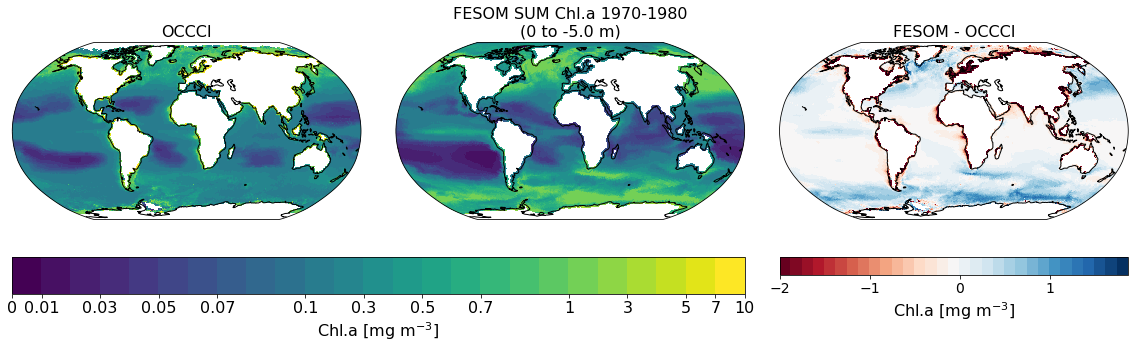


Statistics for log10 surface Chlorophyll

Original Taylor stats:
SDEV pred: 0.51539, ref: 0.44571
CRMS pred: 0.45709, ref: 0.00000
CORRCOEF: 0.55581

Normalized Taylor stats:
SDEV pred: 1.15635, ref: 1.00000
CRMS pred: 1.02554, ref: 0.00000
CORRCOEF: 0.55581


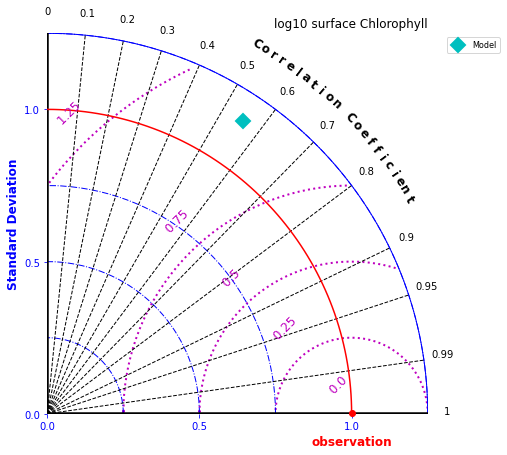

In [120]:
### TESTING ###
if __name__ == "__main__":
    
    # run specification -------------------------------------------------------------------------------------
    runid      =  'fesom'
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/' + 'mo12'
    savepath = '/home/ollie/mozeisin/evaluation/mo_files/mo12/'

    htmlname     =  runid + '.html'
    htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    #modulepath = '/home/ollie/mozeisin/py_recom/GlobalAssessment'
    #modulepath   = '/home/ollie/jhauck/py_fesom/modules/'

    #obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

    # period of analysis ------------------------------------------------------------------------------------

    first_year = 1970
    last_year  = 1980

    # OCCCI ------------------------------------------------------------------------------------  
    matfileChlsurf           = '/work/ollie/projects/MarESys/evaluation/climatology_annual_chl_1deg_OCCCI_2012_2015.mat'
    
    # now test:
    test = Chlsurf_OCCCI_comp(runid,resultpath,savepath,meshpath,matfileChlsurf,first_year,last_year,
                              mapproj = 'rob',
                              layerwise=False,savefig=False,
                             n_levels=1)